<h4>Extramarital Affairs Dataset</h4>

The dataset is affairs dataset and comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a 1978 paper from the Journal of Political Economy.

Description of Variables
The dataset contains 6366 observations of 9 variables:

<li>rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good) <br>
<li>age: woman's age <br>
<li>yrs_married: number of years married <br>
<li>children: number of children <br>
<li>religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious) <br>
<li>educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college  <br> graduate, 17 = some graduate school, 20 = advanced degree) <br>
<li>occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", <br> 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree) <br>
<li>occupation_husb: husband's occupation (same coding as above) <br>
<li>affairs: time spent in extra-marital affairs <br>

<h4>Problem Statement</h4>
We treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and try to predict the classification for each woman.

<h4>Import Modules</h4>

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h4>Preprocessing</h4>

In [2]:
# load dataset
dta = sm.datasets.fair.load_pandas().data

# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

<h4>Data Exploration</h4>

In [3]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


We can see that on average, women who have affairs rate their marriages lower, 
which is to be expected. Let's take another look at the rate_marriage variable.

In [4]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


An increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

<h4>Data Visualization</h4>

Text(0,0.5,'Frequency')

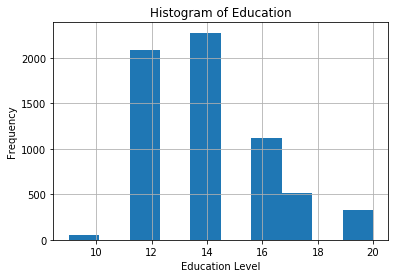

In [5]:
# show plots in the notebook
%matplotlib inline

# histogram of education
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

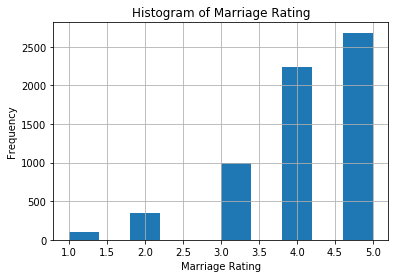

In [6]:
# histogram of marriage rating
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.

Text(0,0.5,'Frequency')

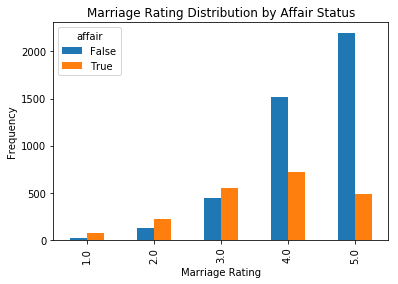

In [7]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

Text(0,0.5,'Percentage')

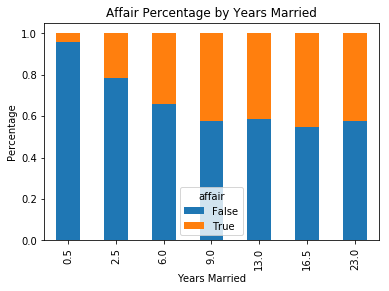

In [8]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

<h4>Prepare Data for Logistic Regression</h4>

In [9]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  dta, return_type="dataframe")
# print X.columns

# rename column names for the dummy variables for better looks:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

# and flatten y into a 1-D array so that scikit-learn will properly understand it as the response variable.
y = np.ravel(y)

<h4>Logistic Regression</h4>

In [10]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.7258875274897895

72% accuracy may seem OK, but what's the accuracy if we simply predict no for all observations in the dataset?

In [11]:
# what percentage had affairs?
y.mean()

0.3224945020420987

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting no. So we're doing better than the null error rate, but not by much.

Increases in marriage rating and religiousness correspond to a decrease in the likelihood of having an affair. For both the wife's occupation and the husband's occupation, the lowest likelihood of having an affair corresponds to the baseline occupation (student), since all of the dummy coefficients are positive.

In [14]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

# predict class labels for the test set
predicted = model2.predict(X_test)
predicted

# generate class probabilities
probs = model2.predict_proba(X_test)
probs

array([[0.35142488, 0.64857512],
       [0.90952576, 0.09047424],
       [0.72576603, 0.27423397],
       ...,
       [0.55736751, 0.44263249],
       [0.81213933, 0.18786067],
       [0.74729595, 0.25270405]])

The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

In [16]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.7298429319371728
0.7459619860896347


In [17]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[1169  134]
 [ 382  225]]
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910



<h4>Model Evaluation Using Cross-Validation</h4>

In [18]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
scores, scores.mean()

(array([0.72100313, 0.70219436, 0.73824451, 0.70597484, 0.70597484,
        0.72955975, 0.7327044 , 0.70440252, 0.75157233, 0.75      ]),
 0.7241630685514876)

Still performing at 73% accuracy.

<h4>Predicting the Probability of an Affair</h4>

Let's predict the probability of an affair for a random woman not present in the dataset. She's a 25-year-old teacher who graduated college, has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer.

In [19]:
model.predict_proba(np.array([[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4,
                              16]]))

array([[0.7747227, 0.2252773]])

The predicted probability of an affair is 23%.

<h4>Improving the Model</h4>
The following could be tried to improve the model:

<li>including interaction terms
<li>removing features
<li>regularization techniques
<li>using a non-linear model